<a href="https://colab.research.google.com/github/jacob-danner/machine-learning-experiments/blob/main/MNIST/MNIST_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
import torch
import torch.nn as nn
from torch import Tensor, tensor

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim import SGD

import numpy as np

from PIL import Image

In [82]:
!pip install -q torch-lr-finder
from torch_lr_finder import LRFinder

In [83]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('GPU is not available, using the CPU instead.')

Using GPU: Tesla T4


In [85]:
# transforms

class FlattenImage():
    def __call__(self, x):
        return x.view(28*28)

transforms = transforms.Compose([
    transforms.ToTensor(),
    FlattenImage()
])

In [86]:
mnist = datasets.MNIST(root='./data', train=True, transform=transforms, download=True)
mnist_loader = DataLoader(dataset=mnist, batch_size=64, shuffle=True)

In [150]:
class MLP(nn.Module):
    '''
    input layer = 784
    output layer = 10
    '''

    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 200),
            nn.ReLU(),
            nn.Linear(200, 10),
        )

    def forward(self, x):
        return self.layers(x)

In [90]:
from typing import Callable
from dataclasses import dataclass

def train_one_epoch(model: MLP, dataloader: DataLoader, loss_fn: Callable[[Tensor, Tensor], Tensor], optimizer: torch.optim.Optimizer) -> float:
    epoch_running_loss = 0

    for batch in dataloader:
        inputs, labels = batch

        inputs = inputs.to(device) #  move to GPU if available
        labels = labels.to(device) #  move to GPU if available

        optimizer.zero_grad() # zero gradients

        predictions = model(inputs)

        # compute loss and propogate gradients
        loss = loss_fn(predictions, labels)
        loss.backward()

        optimizer.step()

        # update metainformation
        epoch_running_loss += loss.item()

    epoch_avg_loss = epoch_running_loss / len(dataloader)
    return epoch_avg_loss


def train_n_epochs(n: int, model: MLP, dataloader: DataLoader, loss_fn: Callable[[Tensor, Tensor], Tensor], optimizer: torch.optim.Optimizer) -> None:
    for i in range(n):
        epoch_avg_loss = train_one_epoch(model, dataloader, loss_fn, optimizer)
        print(f'epoch {i}: {epoch_avg_loss = }')


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.15E-01


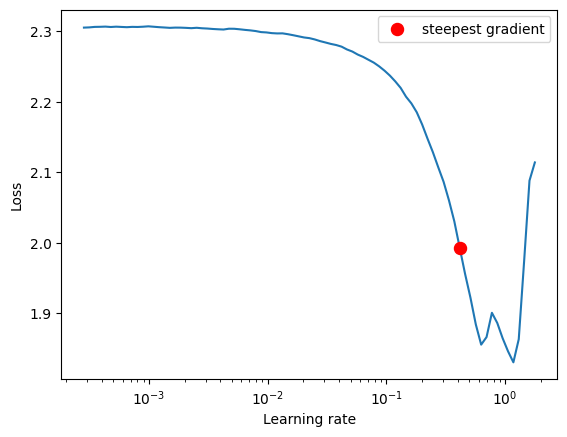

epoch 0: epoch_avg_loss = 0.44673831235450595
epoch 1: epoch_avg_loss = 0.1592848012263555
epoch 2: epoch_avg_loss = 0.12207175021730998
epoch 3: epoch_avg_loss = 0.10239555028233446
epoch 4: epoch_avg_loss = 0.08754908752420158
epoch 5: epoch_avg_loss = 0.07560732398035207
epoch 6: epoch_avg_loss = 0.06674801096764964
epoch 7: epoch_avg_loss = 0.058991075964269245
epoch 8: epoch_avg_loss = 0.05477143449672579
epoch 9: epoch_avg_loss = 0.047476399157604356
epoch 10: epoch_avg_loss = 0.042550635289277695
epoch 11: epoch_avg_loss = 0.03977312294036291
epoch 12: epoch_avg_loss = 0.035976782628979936
epoch 13: epoch_avg_loss = 0.03130583850399299
epoch 14: epoch_avg_loss = 0.0302588072703354
epoch 15: epoch_avg_loss = 0.02456943720591186
epoch 16: epoch_avg_loss = 0.023790782149846375
epoch 17: epoch_avg_loss = 0.022174786679560382
epoch 18: epoch_avg_loss = 0.018929089176939425
epoch 19: epoch_avg_loss = 0.01775975528625437
epoch 20: epoch_avg_loss = 0.014171183196377746
epoch 21: epoch_a

In [152]:
def update_optimizer_lr(optimizer, new_lr):
    """Update the learning rate of an optimizer."""
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

model = MLP()
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = SGD(lr=.0001, params=model.parameters())

# update learning rate
lr_finder = LRFinder(model, optimizer, loss_fn, device=device)
lr_finder.range_test(mnist_loader, end_lr=3, num_iter=100)
min_grad_idx = (np.gradient(np.array(lr_finder.history['loss']))).argmin()
optimal_lr = lr_finder.history['lr'][min_grad_idx]

update_optimizer_lr(optimizer, optimal_lr)

lr_finder.plot()

n_epochs = 25
train_n_epochs(n_epochs, model, mnist_loader, loss_fn, optimizer)

# Test

In [106]:
mnist_test = datasets.MNIST(root='./data', train=False, transform=transforms, download=True)
mnist_test_loader = DataLoader(dataset=mnist_test, batch_size=64, shuffle=True)

In [156]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in mnist_test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        logits = model(inputs)

        _, predictions = torch.max(logits, 1)

        # predictions.shape = [64]
        # labels.shape = [64]

        total += len(inputs)
        correct += (predictions == labels).sum().item()

accuracy = correct / total
print(f'Accuracy of the model on the MNIST test images: {accuracy * 100}%')

Accuracy of the model on the MNIST test images: 97.47%


# Multi Class Classification in Pytorch

__NOTE__: This may not be 100% accurate, but captures the main concepts.

The default implementation of cross entropy loss takes in probabiliy distribution (from softmax), and calculates the negative log of the corresponding probability (the value at the index of the real category). In other words, compare the predictetd distribution to the real distribution. This is called the negative log likelihood.

For computational efficiency as well as numerical stability, in PyTorch, you don't use softmax first. You directly feed the logits (output from network) to the loss function. Under the hood the loss function:

- calculates probability distribution (not using softmax)
- looks up the value of the probability at the index of the real category
- calculates the negative log of the value

Pseudocode example:

```python
real_category = 2
probabilities = [.25, .25, .5] # softmax output
corresponding_probability = probabilities[real_category]
loss = -torch.log(corresponding_probability)
```

This is conceptually the same as:
```python
loss = nn.CrossEntropyLoss()(logits.unsqueeze(0), tensor([true_class]))
```

Real runnable example code:
```python

logits = torch.randn(5)
print(f'{logits = }')
print(f'{logits.unsqueeze(0) = }', '\n')

probabilites = nn.Softmax(0)(logits)
print(f'{probabilites = }', '\n')

true_class = 3

manual_loss = -torch.log(probabilites[true_class])
print(f'{probabilites[true_class] = }')
print(f'{manual_loss = }', '\n')

auto_loss = nn.CrossEntropyLoss()(logits.unsqueeze(0), tensor([true_class]))
print(f'{auto_loss = }')
```